In [1]:
import pandas as pd
import numpy as np
import time
from pathlib import Path
import os
import datetime
from datetime import datetime, date, timedelta
import openpyxl
from openpyxl.styles.fonts import Font
from openpyxl.styles.alignment import Alignment
from openpyxl.styles import PatternFill, colors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
import seaborn as sns

In [2]:
file_path = Path.home() / 'leave_project_2.1'

In [3]:
# 구글 폼으로 제출된 휴가 등 신청 관련 원본자료를 Pandas로 출력
# parse_dates 파라미터를 통해 pandas Timestamp 형식으로 변환 → 나중에 순환문 돌면서 변환할 필요 없음
leave_df = pd.read_excel(file_path / '원본자료(비식별화).xlsx', sheet_name='시트1', parse_dates=['부재 시작일은 언제입니까?', '부재 종료일은 언제입니까? (2일 이상의 부재인 경우만 기재)'])
leave_df

,이름,부재 일수를 적어주세요.(업무일 기준),부재 시작일은 언제입니까?,부재 종료일은 언제입니까? (2일 이상의 부재인 경우만 기재),부재 사유는 무엇입니까?
0,조윤아,5일,2020-01-20,2020-02-03,연차(일반)
1,이준우,1일,2020-01-02,NaT,연차(일반)
2,이준우,0.5일(오후),2020-01-03,NaT,연차(일반)
3,이준우,0.5일(오후),2020-01-08,NaT,연차(일반)
4,조윤아,1일,2020-01-03,NaT,연차(일반)
...,...,...,...,...,...
5031,장준연,0.5일(오전),2022-09-16,NaT,연차(병가)
5032,정예후,1일,2022-09-19,NaT,연차(일반)
5033,임은현,0.5일(오후),2022-09-16,NaT,연차(병가)
5034,강주윤,1일,2022-09-23,NaT,연차(일반)


In [4]:
# 부서 등 개인정보 원본자료를 Pandas 출력
info_df = pd.read_excel(file_path / '원본자료(비식별화).xlsx', sheet_name='시트2', parse_dates=['시작일', '종료일'])
info_df

,구분,성명,소속,시작일,종료일,근속월수
0,퇴사(정규직),정윤호,운영팀,2012-06-24,2021-10-31,112.21
1,정규직,김채진,영업/마케팅팀,2012-08-25,2022-09-17,120.73
2,정규직,장민우,연구개발팀,2012-08-25,2022-09-17,120.73
3,정규직,윤윤원,연구개발팀,2013-07-29,2022-09-17,109.65
4,퇴사(정규직),윤준윤,운영팀,2015-03-11,2022-07-31,88.67
...,...,...,...,...,...,...
101,퇴사(기타),정지원,운영팀,2016-03-07,2016-06-13,3.21
102,퇴사(기타),박주진,영업/마케팅팀,2018-03-08,2018-06-30,3.75
103,퇴사(기타),윤준우,영업/마케팅팀,2019-03-11,2019-06-17,3.22
104,퇴사(기타),조도우,운영팀,2019-03-11,2019-05-31,2.66


In [5]:
leave_rename_cols = {'부재 일수를 적어주세요.(업무일 기준)':'부재일수', '부재 시작일은 언제입니까?':'부재시작일',
       '부재 종료일은 언제입니까? (2일 이상의 부재인 경우만 기재)':'부재종료일', '부재 사유는 무엇입니까?':'부재사유'}

In [6]:
leave_df = (leave_df
.rename(leave_rename_cols, axis=1)
# np.where보다는 fillna() 메서드를 이용하는 것이 훨씬 깔끔
.assign(부재종료일=lambda df: df['부재종료일'].fillna(df['부재시작일']))
.assign(반차여부=lambda df: np.where(df['부재일수'].isin(['0.5일(오전)', '0.5일(오후)']), 'Yes', 'No'))
# str 속성 사용하여 부재사유 이름 변경
.assign(부재사유=lambda df: df['부재사유'].str.slice(0, 2))
.loc[:, ['이름', '부재일수', '부재사유', '반차여부', '부재시작일', '부재종료일']]
)
leave_df

,이름,부재일수,부재사유,반차여부,부재시작일,부재종료일
0,조윤아,5일,연차,No,2020-01-20,2020-02-03
1,이준우,1일,연차,No,2020-01-02,2020-01-02
2,이준우,0.5일(오후),연차,Yes,2020-01-03,2020-01-03
3,이준우,0.5일(오후),연차,Yes,2020-01-08,2020-01-08
4,조윤아,1일,연차,No,2020-01-03,2020-01-03
...,...,...,...,...,...,...
5031,장준연,0.5일(오전),연차,Yes,2022-09-16,2022-09-16
5032,정예후,1일,연차,No,2022-09-19,2022-09-19
5033,임은현,0.5일(오후),연차,Yes,2022-09-16,2022-09-16
5034,강주윤,1일,연차,No,2022-09-23,2022-09-23


In [7]:
# 부재종료일이 잘못 입력되어있는 경우를 찾아 올바른 값으로 수정
leave_df[(leave_df['부재종료일'] - leave_df['부재시작일']).lt('0 days')]
leave_df.loc[1216, '부재종료일'] = pd.to_datetime('2021-01-08')
leave_df.loc[2057, '부재종료일'] = pd.to_datetime('2021-07-23')
leave_df.loc[4637, '부재종료일'] = pd.to_datetime('2021-06-21')

In [8]:
leave_df = (leave_df
.reset_index(drop=True)
.rename({'부재시작일':'Days1'}, axis=1)
)
leave_df

,이름,부재일수,부재사유,반차여부,Days1,부재종료일
0,조윤아,5일,연차,No,2020-01-20,2020-02-03
1,이준우,1일,연차,No,2020-01-02,2020-01-02
2,이준우,0.5일(오후),연차,Yes,2020-01-03,2020-01-03
3,이준우,0.5일(오후),연차,Yes,2020-01-08,2020-01-08
4,조윤아,1일,연차,No,2020-01-03,2020-01-03
...,...,...,...,...,...,...
5031,장준연,0.5일(오전),연차,Yes,2022-09-16,2022-09-16
5032,정예후,1일,연차,No,2022-09-19,2022-09-19
5033,임은현,0.5일(오후),연차,Yes,2022-09-16,2022-09-16
5034,강주윤,1일,연차,No,2022-09-23,2022-09-23


In [9]:
for i in range(2, int((leave_df['부재종료일'] - leave_df['Days1']).max() / '1 days') + 1):
    leave_df = (leave_df.assign(**{f'Days{i}':np.where(leave_df['부재종료일'].eq(leave_df[f'Days{i-1}']), leave_df[f'Days{i-1}'], leave_df[f'Days{i-1}'] + timedelta(days=1))})
    )
leave_df = (leave_df
.drop('부재종료일', axis=1))
leave_df

,이름,부재일수,부재사유,반차여부,Days1,Days2,Days3,Days4,Days5,Days6,Days7,Days8,Days9,Days10,Days11,Days12,Days13,Days14,Days15
0,조윤아,5일,연차,No,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03
1,이준우,1일,연차,No,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02,2020-01-02
2,이준우,0.5일(오후),연차,Yes,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03
3,이준우,0.5일(오후),연차,Yes,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08,2020-01-08
4,조윤아,1일,연차,No,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03,2020-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5031,장준연,0.5일(오전),연차,Yes,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16
5032,정예후,1일,연차,No,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19,2022-09-19
5033,임은현,0.5일(오후),연차,Yes,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16,2022-09-16
5034,강주윤,1일,연차,No,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23,2022-09-23


In [10]:
leave_df = (leave_df
.melt(id_vars=['이름', '부재일수', '부재사유', '반차여부'], value_name='부재일시')
.drop_duplicates(subset=['이름', '부재일수', '부재사유', '부재일시'])
.drop('variable', axis=1)
.sort_values('부재일시', ascending=True)
)
leave_df

,이름,부재일수,부재사유,반차여부,부재일시
1,이준우,1일,연차,No,2020-01-02
5,강주윤,2일,연차,No,2020-01-02
6,조도후,1일,연차,No,2020-01-02
7,장채진,1일,연차,No,2020-01-02
2,이준우,0.5일(오후),연차,Yes,2020-01-03
...,...,...,...,...,...
4914,장준연,5,연차,No,2022-11-14
9950,장준연,5,연차,No,2022-11-15
14986,장준연,5,연차,No,2022-11-16
20022,장준연,5,연차,No,2022-11-17


In [11]:
holiday_2020 = ['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-03-01', '2020-04-15', 
               '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-09-30', '2020-10-01', '2020-10-02', 
               '2020-10-03', '2020-10-09', '2020-12-25']
holiday_2021 = ['2021-01-01', '2021-02-11', '2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19',
                '2021-06-06', '2021-08-15', '2021-08-16', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03',
                '2021-10-04', '2021-10-09', '2021-10-11', '2021-12-25']
holiday_2022 = ['2022-01-01', '2022-01-31', '2022-02-01', '2022-02-02', '2022-03-01', '2022-03-09', '2022-05-05', '2022-05-08',
                '2022-06-01', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03',
                '2022-10-09', '2022-10-10', '2022-12-25']

In [12]:
leave_df = leave_df[~leave_df['부재일시'].dt.dayofweek.isin([5, 6]) & ~leave_df['부재일시'].isin(holiday_2020 + holiday_2021 + holiday_2022)]
leave_df

,이름,부재일수,부재사유,반차여부,부재일시
1,이준우,1일,연차,No,2020-01-02
5,강주윤,2일,연차,No,2020-01-02
6,조도후,1일,연차,No,2020-01-02
7,장채진,1일,연차,No,2020-01-02
2,이준우,0.5일(오후),연차,Yes,2020-01-03
...,...,...,...,...,...
4914,장준연,5,연차,No,2022-11-14
9950,장준연,5,연차,No,2022-11-15
14986,장준연,5,연차,No,2022-11-16
20022,장준연,5,연차,No,2022-11-17


In [13]:
leave_df = (leave_df
.assign(반차여부=np.where(leave_df['반차여부'] == 'No', 1, 0.5))
.assign(부재일수=leave_df['부재일수'].str.extract(r'(오전|오후)').fillna('전일'))
.reset_index(drop=True)
)
leave_df

,이름,부재일수,부재사유,반차여부,부재일시
0,이준우,전일,연차,1.0,2020-01-02
1,강주윤,전일,연차,1.0,2020-01-02
2,조도후,전일,연차,1.0,2020-01-02
3,장채진,전일,연차,1.0,2020-01-02
4,이준우,오후,연차,0.5,2020-01-03
...,...,...,...,...,...
7989,장준연,전일,연차,1.0,2022-11-14
7990,장준연,전일,연차,1.0,2022-11-15
7991,장준연,전일,연차,1.0,2022-11-16
7992,장준연,전일,연차,1.0,2022-11-17


In [14]:
total_df = (leave_df
.merge(info_df, left_on='이름', right_on='성명', how='inner')
.drop(['성명', '구분', '시작일', '종료일', '근속월수'], axis=1)
.assign(부재요일=lambda df: df['부재일시'].dt.dayofweek.replace(dict(enumerate(['월', '화', '수', '목', '금', '토', '일']))))
.reindex(['이름', '소속', '부재일수', '부재사유', '반차여부', '부재일시', '부재요일'], axis=1)
.sort_values('부재일시', ascending=True)
)
total_df

,이름,소속,부재일수,부재사유,반차여부,부재일시,부재요일
0,이준우,영업/마케팅팀,전일,연차,1.0,2020-01-02,목
398,장채진,영업/마케팅팀,전일,연차,1.0,2020-01-02,목
287,조도후,영업/마케팅팀,전일,연차,1.0,2020-01-02,목
161,강주윤,영업/마케팅팀,전일,연차,1.0,2020-01-02,목
648,박하태,영업/마케팅팀,전일,연차,1.0,2020-01-03,금
...,...,...,...,...,...,...,...
7908,장준연,연구개발팀,전일,연차,1.0,2022-11-14,월
7909,장준연,연구개발팀,전일,연차,1.0,2022-11-15,화
7910,장준연,연구개발팀,전일,연차,1.0,2022-11-16,수
7911,장준연,연구개발팀,전일,연차,1.0,2022-11-17,목


In [15]:
summary_df = (leave_df
.groupby([leave_df['부재일시'].dt.year.rename('연도'), '이름', '부재사유'])['반차여부']
.sum()
.unstack()
.rename_axis(None, axis=1)
.reset_index()
.fillna(0)
.merge(info_df, left_on='이름', right_on='성명', how='inner')
.drop(['성명', '근속월수'], axis=1)
.loc[:, ['연도', '이름', '구분', '소속', '시작일', '종료일', '연차', '재택', '출장']]
.sort_values(['연도', '시작일'], ascending=True)
.reset_index(drop=True)
)
summary_df

,연도,이름,구분,소속,시작일,종료일,연차,재택,출장
0,2020,정윤호,퇴사(정규직),운영팀,2012-06-24,2021-10-31,15.5,4.5,0.0
1,2020,김채진,정규직,영업/마케팅팀,2012-08-25,2022-09-17,18.0,97.0,0.0
2,2020,장민우,정규직,연구개발팀,2012-08-25,2022-09-17,16.0,30.5,0.0
3,2020,윤윤원,정규직,연구개발팀,2013-07-29,2022-09-17,17.0,15.5,0.0
4,2020,윤준윤,퇴사(정규직),운영팀,2015-03-11,2022-07-31,18.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...
158,2022,임현은,정규직,영업/마케팅팀,2022-06-30,2022-09-17,4.0,0.0,0.0
159,2022,임윤우,인턴,연구개발팀,2022-07-04,2022-09-17,4.0,0.0,0.0
160,2022,장하태,인턴,연구개발팀,2022-07-11,2022-09-17,5.0,7.0,0.0
161,2022,임도서,정규직,연구개발팀,2022-07-18,2022-09-17,3.5,0.0,0.0


In [16]:
year_start = (summary_df['시작일']
.clip(lower=pd.to_datetime(summary_df['연도'].astype('str')+'-01-01'))
)
year_end = (summary_df['종료일']
.clip(upper=pd.to_datetime(summary_df['연도'].astype('str')+'-12-31'))
)

In [17]:
summary_df = (summary_df
.assign(연간일수=((year_end - year_start + pd.to_timedelta('1 days')) / pd.to_timedelta('1 days')).astype('int').clip(upper=365))
.reindex(['연도', '이름', '구분', '소속', '시작일', '종료일', '연간일수', '연차', '재택', '출장'], axis=1)
)
summary_df

,연도,이름,구분,소속,시작일,종료일,연간일수,연차,재택,출장
0,2020,정윤호,퇴사(정규직),운영팀,2012-06-24,2021-10-31,365,15.5,4.5,0.0
1,2020,김채진,정규직,영업/마케팅팀,2012-08-25,2022-09-17,365,18.0,97.0,0.0
2,2020,장민우,정규직,연구개발팀,2012-08-25,2022-09-17,365,16.0,30.5,0.0
3,2020,윤윤원,정규직,연구개발팀,2013-07-29,2022-09-17,365,17.0,15.5,0.0
4,2020,윤준윤,퇴사(정규직),운영팀,2015-03-11,2022-07-31,365,18.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...,...
158,2022,임현은,정규직,영업/마케팅팀,2022-06-30,2022-09-17,80,4.0,0.0,0.0
159,2022,임윤우,인턴,연구개발팀,2022-07-04,2022-09-17,76,4.0,0.0,0.0
160,2022,장하태,인턴,연구개발팀,2022-07-11,2022-09-17,69,5.0,7.0,0.0
161,2022,임도서,정규직,연구개발팀,2022-07-18,2022-09-17,62,3.5,0.0,0.0


In [18]:
excel_file = pd.ExcelWriter(file_path / '가공완료자료.xlsx', engine='xlsxwriter')
summary_df.to_excel(excel_file, sheet_name='요약', index=False)
total_df.to_excel(excel_file, sheet_name='세부자료', index=False)
excel_file.save()

In [19]:
excel_file = openpyxl.load_workbook(file_path / '가공완료자료.xlsx')
for sheet_name in ['요약', '세부자료']:
    sheet = excel_file[sheet_name]
    bold_font = Font(bold=True)
    center_alignment = Alignment(horizontal='center', vertical='center')
    yellow_fill = PatternFill(start_color='00FFFF00', end_color='00FFFF00', fill_type='solid')
    for i in range(1, sheet.max_column + 1):
        sheet.cell(1, i).font = bold_font
        sheet.cell(1, i).alignment = center_alignment
        sheet.cell(1, i).fill = yellow_fill
sheet = excel_file['요약']
sheet.column_dimensions['C'].width = 12
sheet.column_dimensions['D'].width = 14
sheet.column_dimensions['E'].width = 18
sheet.column_dimensions['F'].width = 18
sheet = excel_file['세부자료']
sheet.column_dimensions['B'].width = 14
sheet.column_dimensions['F'].width = 18
excel_file.save(file_path / '가공완료자료.xlsx')

In [20]:
modify_summary_df = (summary_df
.assign(연차2=lambda df: df['연차'].mul(365).div(df['연간일수']).round(1),
재택2=lambda df: df['재택'].mul(365).div(df['연간일수']).round(1),
출장2=lambda df: df['출장'].mul(365).div(df['연간일수']).round(1))
)
modify_summary_df

,연도,이름,구분,소속,시작일,종료일,연간일수,연차,재택,출장,연차2,재택2,출장2
0,2020,정윤호,퇴사(정규직),운영팀,2012-06-24,2021-10-31,365,15.5,4.5,0.0,15.5,4.5,0.0
1,2020,김채진,정규직,영업/마케팅팀,2012-08-25,2022-09-17,365,18.0,97.0,0.0,18.0,97.0,0.0
2,2020,장민우,정규직,연구개발팀,2012-08-25,2022-09-17,365,16.0,30.5,0.0,16.0,30.5,0.0
3,2020,윤윤원,정규직,연구개발팀,2013-07-29,2022-09-17,365,17.0,15.5,0.0,17.0,15.5,0.0
4,2020,윤준윤,퇴사(정규직),운영팀,2015-03-11,2022-07-31,365,18.0,41.0,0.0,18.0,41.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2022,임현은,정규직,영업/마케팅팀,2022-06-30,2022-09-17,80,4.0,0.0,0.0,18.2,0.0,0.0
159,2022,임윤우,인턴,연구개발팀,2022-07-04,2022-09-17,76,4.0,0.0,0.0,19.2,0.0,0.0
160,2022,장하태,인턴,연구개발팀,2022-07-11,2022-09-17,69,5.0,7.0,0.0,26.4,37.0,0.0
161,2022,임도서,정규직,연구개발팀,2022-07-18,2022-09-17,62,3.5,0.0,0.0,20.6,0.0,0.0


<AxesSubplot:xlabel='소속', ylabel='재택2'>

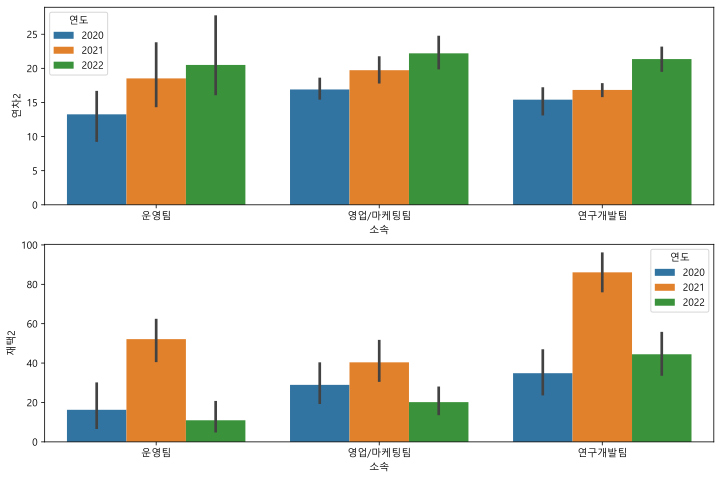

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
sns.barplot(data=modify_summary_df, x='소속', y='연차2', hue='연도', ax=ax1)
sns.barplot(data=modify_summary_df, x='소속', y='재택2', hue='연도', ax=ax2)

In [45]:
modify_summary_df2 = (modify_summary_df
.drop(['연차', '재택', '출장', '출장2', '연간일수'], axis=1)
.set_index(['연도', '이름', '구분', '소속', '시작일', '종료일'])
.stack()
.reset_index()
.rename({'level_6':'부재구분', 0:'부재일수'}, axis=1)
)
modify_summary_df2

,연도,이름,구분,소속,시작일,종료일,부재구분,부재일수
0,2020,정윤호,퇴사(정규직),운영팀,2012-06-24,2021-10-31,연차2,15.5
1,2020,정윤호,퇴사(정규직),운영팀,2012-06-24,2021-10-31,재택2,4.5
2,2020,김채진,정규직,영업/마케팅팀,2012-08-25,2022-09-17,연차2,18.0
3,2020,김채진,정규직,영업/마케팅팀,2012-08-25,2022-09-17,재택2,97.0
4,2020,장민우,정규직,연구개발팀,2012-08-25,2022-09-17,연차2,16.0
...,...,...,...,...,...,...,...,...
321,2022,장하태,인턴,연구개발팀,2022-07-11,2022-09-17,재택2,37.0
322,2022,임도서,정규직,연구개발팀,2022-07-18,2022-09-17,연차2,20.6
323,2022,임도서,정규직,연구개발팀,2022-07-18,2022-09-17,재택2,0.0
324,2022,임은현,정규직,연구개발팀,2022-07-18,2022-09-17,연차2,11.8


<AxesSubplot:xlabel='소속', ylabel='부재일수'>

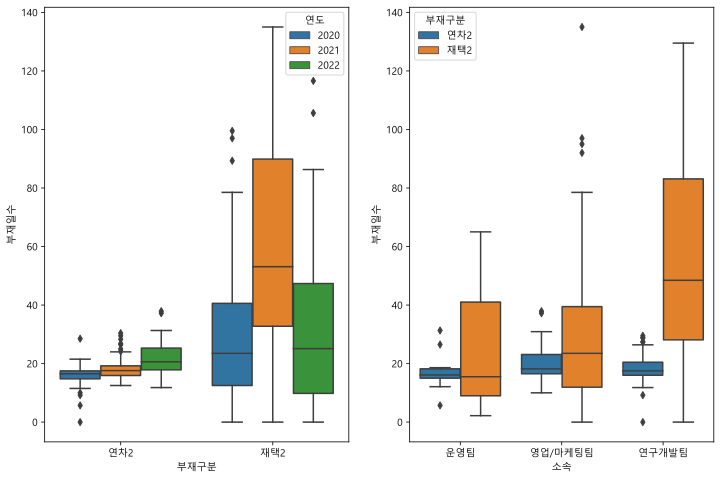

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.boxplot(data=modify_summary_df2, x='부재구분', y='부재일수', hue='연도', ax=ax1)
sns.boxplot(data=modify_summary_df2, x='소속', y='부재일수', hue='부재구분', ax=ax2)

In [89]:
(total_df
.query("부재사유 == '연차'")
.groupby(['소속', '부재요일'])
.apply(lambda df: df['반차여부'].sum(axis=0))
.unstack()
.reindex(['월', '화', '수', '목', '금'], axis=1)
# pipe 메서드를 통해 DataFrame 전체 변환
.pipe(lambda df: df.div(df.sum(axis=1), axis=0))
.round(3)
)

부재요일,월,화,수,목,금
소속,,,,,
연구개발팀,0.171,0.176,0.162,0.195,0.295
영업/마케팅팀,0.187,0.176,0.176,0.184,0.277
운영팀,0.141,0.146,0.192,0.214,0.307
